In [28]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/colorectal/
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 color-28-28.ipynb
 colorectal-histology-predictions-cnn-88-accuracy.ipynb
 color_eval_augment_ig_generator.ipynb
 color_eval_augment.ipynb
 color_eval_origin_ig_generator.ipynb
 color_eval_origin.ipynb
 cwgan-gp-color.ipynb
 DCGAN_augment.ipynb
 example.png
'GAN256 - Heels Zippo.ipynb'
 gan_training
 hmnist_28_28_L.csv
 hmnist_64_64_L.csv
 images
 weights.hdf5
[Errno 2] No such file or directory: 'gdrive/My Drive/colorectal/'
/content/gdrive/My Drive/colorectal
 color-28-28.ipynb
 colorectal-histology-predictions-cnn-88-accuracy.ipynb
 color_eval_augment_ig_generator.ipynb
 color_eval_augment.ipynb
 color_eval_origin_ig_generator.ipynb
 color_eval_origin.ipynb
 cwgan-gp-color.ipynb
 DCGAN_augment.ipynb
 example.png
'GAN256 - Heels Zippo.ipynb'
 gan_training
 hmnist_28_28_L.csv
 hmnist_64_64_L.csv
 images
 weights.hdf5


In [29]:
!nvidia-smi

Tue Mar  7 09:21:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    28W /  70W |   1083MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
# importing the libraries

import numpy as np 
import pandas as pd 

# from tensorflow import keras
# # from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
# # from keras.models import Sequential
# # from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix

In [31]:
#data = pd.read_csv("../input/hmnist_64_64_L.csv")      # reading the data
data = pd.read_csv("./hmnist_28_28_L.csv")      # reading the data

In [32]:
Y = data["label"]
data.drop(["label"],axis=1, inplace=True)
X = data

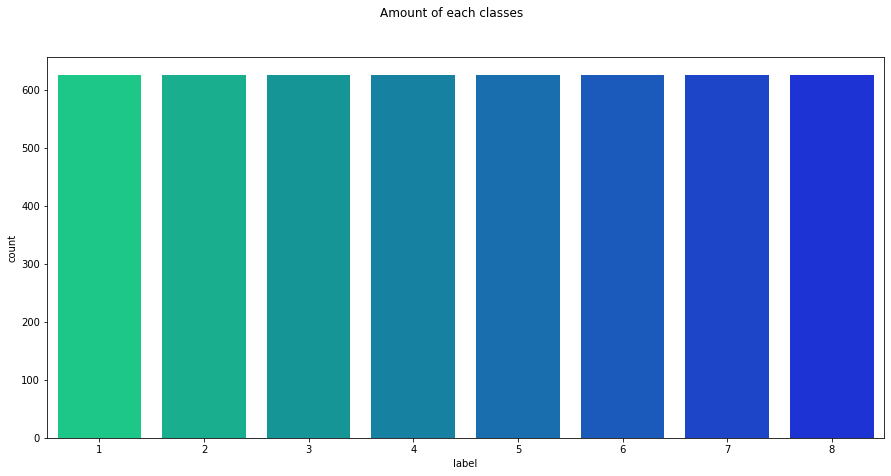

In [33]:
# creating the countplot

plt.figure(figsize=(15,7))
g = sns.countplot(Y, palette="winter_r")
plt.suptitle("Amount of each classes")
plt.show()

In [34]:
# it is very well balanced
Y.value_counts()  

2    625
5    625
7    625
6    625
8    625
1    625
4    625
3    625
Name: label, dtype: int64

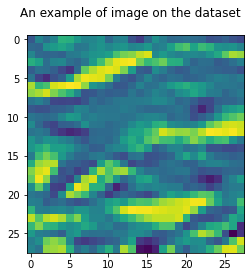

In [35]:
#img = X.iloc[75].as_matrix()  #old
img = X.iloc[75].to_numpy()  #leon, new
img = img.reshape(28,28)
plt.imshow(img)
plt.suptitle("An example of image on the dataset")
plt.show()

In [36]:
# Reshaping
img_size=28
IMG_SHAPE = (28, 28, 1)
# X = X.values.reshape(-1,28,28,1)       # shaping for the Keras
# Y = Y.values

In [37]:
 # Splitting train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
# normalize
#x_train = (x_train - 127.5) / 127.5
#x_train = x_train.astype("float32") / 255.0
x_train = np.array(x_train).reshape(-1, img_size, img_size, 1)
# x_train = x_train.reshape(x_train.shape[0], *IMG_SHAPE).astype("float32")
# x_train = np.reshape(x_train, (-1, img_size, img_size, 1))

#all_digits = all_digits.astype("float32") / 255.0
# x_train = np.reshape(x_train, (-1, img_size, img_size, 1))

#label-1 to match one hot encoder
y_train = y_train - 1  
y_test = y_test - 1
#
print(y_train.value_counts())
y_train = np.array(y_train) #convert to np.array


5    513
3    510
6    507
7    499
4    496
0    496
2    495
1    484
Name: label, dtype: int64


In [38]:
print("x_train.shape: ",x_train.shape)
print("x_test.shape: ",x_test.shape)
print("y_train.shape: ",y_train.shape)
print("y_test.shape: ",y_test.shape)
# print(x_train[0:5])


x_train.shape:  (4000, 28, 28, 1)
x_test.shape:  (1000, 784)
y_train.shape:  (4000,)
y_test.shape:  (1000,)


In [39]:
#***evaluate on origin data and augmented data together
from tensorflow import keras
import tensorflow as tf
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import time
import numpy as np
from random import *
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow import set_random_seed
from keras.preprocessing.image import ImageDataGenerator



Original colorectal dataset:  (4000, 28, 28, 1) (4000,)
Original number of images with  0 :  496
New number of images with  0 :  496
Now adding GAN data ...
New colorectal:  (4250, 28, 28, 1) (4250,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 dropout_6 (Dropout)         (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 dropout_7 (Dropout)         (None, 14, 14, 32)     

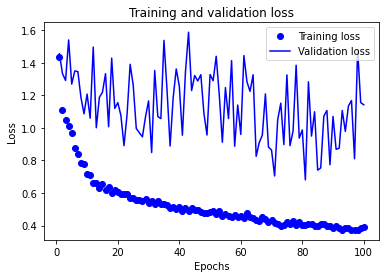

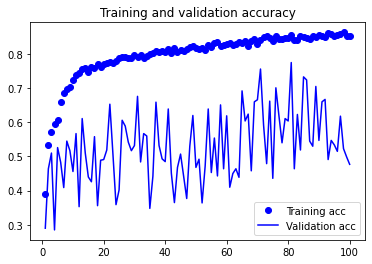

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.33      0.49       129
           1       0.62      0.74      0.68       141
           2       0.40      0.60      0.48       130
           3       0.54      0.98      0.70       115
           4       0.17      0.37      0.23       129
           5       0.93      0.67      0.78       112
           6       1.00      0.13      0.23       118
           7       0.00      0.00      0.00       126

    accuracy                           0.48      1000
   macro avg       0.57      0.48      0.45      1000
weighted avg       0.56      0.48      0.44      1000



In [40]:
# Define parameters
batch_size = 32 #128
num_classes = 8
epochs = 100
img_rows, img_cols = 28, 28	# Input image dimensions

labels = [0]			# Reduce the 'T-shirt/Top' class

# x_train = x_train.values
x_test = x_test.values

'''Preprocess'''

if K.image_data_format() == 'channels_first':
	x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
	x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
	input_shape = (1, img_rows, img_cols)
else:
	x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
	x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
	input_shape = (img_rows, img_cols, 1)


# Unbalance data
print ("Original colorectal dataset: ",x_train.shape, y_train.shape)

for label in labels:
	# Get number of samples of '6' and their indices
	indices = np.where(y_train == label)[0]
	n = len(indices)
	print ("Original number of images with ",label, ": ",n)
	'''
	# Delete a random 50% of n
	delete_index = sample(list(indices), int(0.5*n))
	x_train = np.delete(x_train, delete_index, 0)
	y_train = np.delete(y_train, delete_index, 0)
	'''
	print ("New number of images with ",label, ": ",len(np.where(y_train == label)[0]))
	print ("Now adding GAN data ...")

	# Load synthetic data
	x_gen = np.load('images/x_train_class_%d.npy' % label)

	# Normalize data
	x_gen = np.abs(x_gen)
	x_gen *= 255
	x_gen = x_gen.astype(np.uint8)
	x_gen = np.reshape(x_gen, (x_gen.shape[0], 28, 28, 1))
	
	y_gen = np.load('images/y_train_class_%d.npy' % label)
	y_gen = y_gen.astype(int)

	# Combine both datasets and shuffle
	x_train = np.concatenate((x_train, x_gen))
	y_train = np.concatenate((y_train, y_gen))
	x_train, y_train = shuffle(x_train, y_train, random_state=0)

print ("New colorectal: ",x_train.shape, y_train.shape)
# Normalize data
x_train = x_train.astype('float32')  
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


''' Train Model '''

# # Define model  #old
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(num_classes, activation='softmax'))
# ###

#new trained model code
# set_random_seed(42)
tf.random.set_seed(42) #leon

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                verbose=1, save_best_only=True)
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = 2)) 

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = 2))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))

model.add(GlobalMaxPooling2D())
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()
####

# Fit model
start = time.time()
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

# model.fit(train_tensors, train_targets, 
#           validation_data=(val_tensors, val_targets),
#           epochs=epochs, batch_size=20, verbose=1, callbacks = [early_stopping, checkpointer])
# model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1,callbacks = [early_stopping, checkpointer])

train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
									 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
									 horizontal_flip=True, fill_mode="nearest")

# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1)

history = model.fit(train_datagen.flow(x_train,y_train,
                     batch_size=batch_size, 
                     seed=27,
                     shuffle=False),
                     epochs=epochs,
                     steps_per_epoch=x_train.shape[0] // batch_size,
                     validation_data=(x_test,y_test),
                     verbose=1)
# Evaluate model
end = time.time()
print ("Time: ", (start-end))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#display loss, accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss, 'bo', label = 'Training loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
plt.plot(epochs, acc,'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
###

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
#y_pred = model.predict_classes(x_test)  #old version
y_pred = np.argmax(model.predict(x_test), axis=-1)  #leon, new version
print(classification_report(Y_test, y_pred))




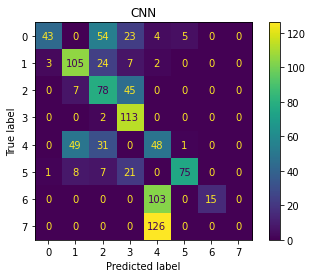

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
class_names_num = ['0', '1', '2', '3', '4', '5', '6', '7']
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_num)
disp.plot()
_ = disp.ax_.set_title("CNN")
plt.show()